# 1. Import required modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage import data
import skimage
from skimage.filters.thresholding import threshold_li,threshold_local,threshold_otsu
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, remove_small_objects, ball
from skimage.morphology import disk
from scipy import ndimage as ndi
import sys,os, glob

#import skimage.filters.median

#import skimage.segmentation as seg
#import skimage.filters as filters
#import skimage.draw as draw
#import skimage.color as color

#from skimage.filters.thresholding import _cross_entropy
#from skimage.morphology import black_tophat, skeletonize, convex_hull_image


#pip install nd2reader_required for nd2 file reading
from nd2reader import ND2Reader

import pandas as pd

c:\programdata\anaconda3\lib\site-packages\skimage\io\manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


# 2. Process all cropped raw images and masks:

### Combine exp1  211004IF_210921exp_DamMN

In [160]:
data_save_folder = r"D:\Analyzed_CellBio\Stam\Dam_analysis_batchB\211004IF_210921exp_DamMN\segmentations_2_100_crop\*"

sub_folders = [_fd for _fd in glob.glob(data_save_folder)][:3]

for _fd in sub_folders:
    
    _pos_fd_list =  [_fd for _fd in glob.glob(_fd + os.sep + '*')]
    
    for _pos_fd in _pos_fd_list:
        
        _cells = [_f for _f in glob.glob(_pos_fd + os.sep + '*') if "excluded_control_chr" in _f]
        _foci = [_f for _f in glob.glob(_pos_fd + os.sep + '*') if "incoporated_chr" in _f and "within" not in _f]
        
        if len(_cells) > 0:
            
            for _cell in _cells:
                
                _cell_id = _cell.split('\\')[-1].split('_nu')[0]
                _inc = [_focus for _focus in _foci if _cell_id in _focus][0]
                
                _cell_mask = io.imread(_cell)
                _foci_mask = io.imread(_inc)
                
                _noncell_background = (ndi.binary_fill_holes(_cell_mask) == 0) * (_foci_mask == 0)
                _noncell_background = erosion (_noncell_background, disk(10))
                
                _foci_size = np.sum(_foci_mask==255)
                _cell_size = np.sum(_cell_mask==255)
                
                _random_index= np.random.choice(_cell_size, 1)
                _random_yx = [np.where(_cell_mask==255)[0][_random_index],
                              np.where(_cell_mask==255)[1][_random_index]]
                
                _seed_mask = np.zeros(_cell_mask.shape)
                _seed_mask [_random_yx[0][0],_random_yx[1][0]] = 1
                
                _expand_seed = True
                while _expand_seed:
                    _seed_mask = dilation(_seed_mask, disk(3))
                    #print (f'-- Generate seed mask for cell {_cell_id}')
                    _subset_control_mask = _seed_mask * (_cell_mask == 255) * (_foci_mask == 0)
                    if np.sum(_subset_control_mask) >= _foci_size: 
                        _expand_seed = False 
                        #print (f'-- Found control mask for cell {_cell_id}')
                _erode_control_mask = True
                while _erode_control_mask:
                    if np.sum(_subset_control_mask) >= _foci_size + 100:
                        _subset_control_mask = erosion(_subset_control_mask, disk(1))
                    else:
                        _erode_control_mask = False
                
                
                _subset_control_mask_savename =  _cell.split(_cell_id)[0] + f'{_cell_id}_subset_control_chr.tif'
                if os.path.exists(_subset_control_mask_savename):
                    os.remove(_subset_control_mask_savename)
                io.imsave(_subset_control_mask_savename, skimage.img_as_ubyte(_subset_control_mask), check_contrast=False)
                
                
                ch4_file = _cell.split(_cell_id)[0] + f"{_cell_id}_ch_4_raw.tif"
                ch3_file = _cell.split(_cell_id)[0] + f"{_cell_id}_ch_3_raw.tif"
                
                ch4_im = io.imread(ch4_file)
                ch3_im = io.imread(ch3_file)
                
                #ch_save_list = ['H2ax', 'Pol2S5']
                
                h2ax_itensity_subset = np.mean((ch3_im * _subset_control_mask)[_subset_control_mask!=0])                
                h2ax_itensity_whole = np.mean((ch3_im * _cell_mask)[_cell_mask!=0])
                h2ax_itensity_background = np.mean((ch3_im * _noncell_background)[_noncell_background!=0])
                h2ax_itensity_subset_norm = ((h2ax_itensity_subset - h2ax_itensity_background) / 
                                             (h2ax_itensity_whole - h2ax_itensity_background))
                
                
                pol2_itensity_subset = np.mean((ch4_im * _subset_control_mask)[_subset_control_mask!=0])                
                pol2_itensity_whole = np.mean((ch4_im * _cell_mask)[_cell_mask!=0])
                pol2_itensity_background = np.mean((ch4_im * _noncell_background)[_noncell_background!=0])
                pol2_itensity_subset_norm = ((pol2_itensity_subset - pol2_itensity_background) / 
                                             (pol2_itensity_whole - pol2_itensity_background))
                
                
                
                
                
                    
                
                
                
                
                
      
                
                        
            
                        


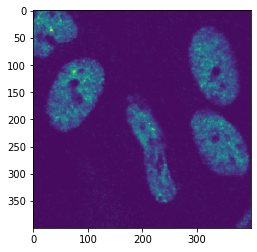

In [169]:
plt.imshow(ch4_im)

In [171]:
h2ax_itensity_subset

h2ax_itensity_whole

32541.192137240887

In [163]:
h2ax_itensity_subset_norm

0.009079017924538848

In [148]:
np.sum(_control_mask)

390.0

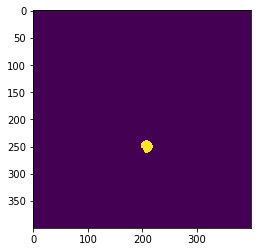

In [164]:
plt.imshow(_subset_control_mask)

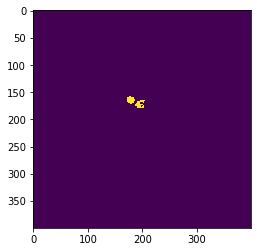

In [165]:
plt.imshow(_foci_mask)

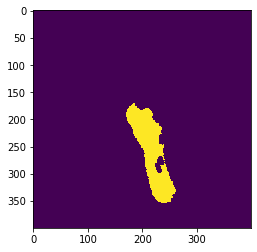

In [166]:
plt.imshow(_cell_mask)

In [91]:
len(combined_df_1)

161

### Combined exp2 211007IF_210922exp_DamMN

In [92]:
# Common parameters for loading the image files of interest

# for 4 channels nd2 images: channel index order is 1-2-3-4, which is the order as ch405-ch488-ch560-ch647


data_save_folder = r"D:\Analyzed_CellBio\Stam\Dam_analysis_batchB\211007IF_210922exp_DamMN\analysis\*"



sub_folders = [_fd for _fd in glob.glob(data_save_folder)]

sub_folders = sorted(sub_folders, key=lambda x: int(x.split('well')[-1]))

combined_df_2 =pd.DataFrame()

for _fd in sub_folders:
    
    
    analysis_excel_name = (_fd + os.sep + 
                           r"measurement_for_all_fov_background_subtracted_2_100_crop.xlsx")
    
    df =  pd.read_excel(analysis_excel_name, index_col=None)
    combined_df_2=  pd.concat([combined_df_2,df])
   

In [93]:
sub_folders

['D:\\Analyzed_CellBio\\Stam\\Dam_analysis_batchB\\211007IF_210922exp_DamMN\\analysis\\well3',
 'D:\\Analyzed_CellBio\\Stam\\Dam_analysis_batchB\\211007IF_210922exp_DamMN\\analysis\\well4',
 'D:\\Analyzed_CellBio\\Stam\\Dam_analysis_batchB\\211007IF_210922exp_DamMN\\analysis\\well5',
 'D:\\Analyzed_CellBio\\Stam\\Dam_analysis_batchB\\211007IF_210922exp_DamMN\\analysis\\well6',
 'D:\\Analyzed_CellBio\\Stam\\Dam_analysis_batchB\\211007IF_210922exp_DamMN\\analysis\\well7']

In [94]:
combined_df_2.insert (1, 'batch_name','211007IF_210922exp_DamMN')

In [95]:
len(combined_df_2)

203

### Combined exp3 211012IF_210927exp_DamMN

In [96]:
# Common parameters for loading the image files of interest

# for 4 channels nd2 images: channel index order is 1-2-3-4, which is the order as ch405-ch488-ch560-ch647




data_save_folder = r"D:\Analyzed_CellBio\Stam\Dam_analysis_batchB\211012IF_210927exp_DamMN\analysis\*"



sub_folders = [_fd for _fd in glob.glob(data_save_folder)]

sub_folders = sorted(sub_folders, key=lambda x: int(x.split('well')[-1]))

combined_df_3 =pd.DataFrame()

for _fd in sub_folders:
    
    
    analysis_excel_name = (_fd + os.sep + 
                           r"measurement_for_all_fov_background_subtracted_2_100_crop.xlsx")
    
    df =  pd.read_excel(analysis_excel_name, index_col=None)
    combined_df_3=  pd.concat([combined_df_3,df])

In [97]:
combined_df_3.insert (1, 'batch_name','211012IF_210927exp_DamMN')

In [98]:
len(combined_df_3)

50

### Combined exp4 210225IF_210201exp_Dam

In [14]:
# Combine all dfs from all exp/batch B

In [100]:
# Common parameters for loading the image files of interest

# for 4 channels nd2 images: channel index order is 1-2-3-4, which is the order as ch405-ch488-ch560-ch647




data_save_folder = r"D:\Analyzed_CellBio\Stam\Dam_analysis_batchB\210225IF_210201exp_Dam\analysis\*"



sub_folders = [_fd for _fd in glob.glob(data_save_folder)]

sub_folders = sorted(sub_folders, key=lambda x: int(x.split('well')[-1]))

combined_df_4 =pd.DataFrame()

for _fd in sub_folders:
    
    
    analysis_excel_name = (_fd + os.sep + 
                           r"measurement_for_all_fov_background_subtracted_2_100_crop.xlsx")
    
    df =  pd.read_excel(analysis_excel_name, index_col=None)
    combined_df_4=  pd.concat([combined_df_4,df])





In [101]:
len (combined_df_4)

55

In [102]:
combined_df_4.insert (1, 'batch_name','210225IF_210201exp_Dam')

In [103]:
combined_df_4

,Unnamed: 0,batch_name,exp_name,position_id,cell_id,cell_xyz_coord,area_incorporated_chr,area_h2ax_within_incorporated_chr,area_less_h2ax_within_incorporated_chr,area_control_chr,...,ave_intensity_nucleo-excluded_control_chr_H2ax,ave_intensity_nucleolus_H2ax,ave_intensity_h2ax_pos_incorporated_chr_H2ax,ave_intensity_h2ax_less_incorporated_chr_H2ax,ave_intensity_incorporated_chr_Pol2S5,ave_intensity_control_chr_Pol2S5,ave_intensity_nucleo-excluded_control_chr_Pol2S5,ave_intensity_nucleolus_Pol2S5,ave_intensity_h2ax_pos_incorporated_chr_Pol2S5,ave_intensity_h2ax_less_incorporated_chr_Pol2S5
0,0,210225IF_210201exp_Dam,well5_doxPlusAID_60x,dox+AIDsm_60x_005.nd2_Pos1,1,"[[1034, 1081], 8]",914,261,653,19729,...,40.557299,23.514143,223.286819,68.348969,36.668383,65.993986,76.087493,16.826980,36.000350,35.630639
1,0,210225IF_210201exp_Dam,well5_doxPlusAID_60x,dox+AIDsm_60x_005.nd2_Pos2,1,"[[1005, 1172], 7]",242,44,198,14376,...,76.469321,39.311806,NaN,118.581238,124.892612,124.498814,145.651870,47.791139,NaN,156.533108
2,0,210225IF_210201exp_Dam,well5_doxPlusAID_60x,dox+AIDsm_60x_005.nd2_Pos4,1,"[[995, 1047], 8]",535,290,245,14956,...,207.135296,94.284363,721.893276,366.336132,217.700778,136.899846,161.236906,37.384431,213.657304,234.037095
3,0,210225IF_210201exp_Dam,well5_doxPlusAID_60x,dox+AIDsm_60x_005.nd2_Pos5,1,"[[979, 1120], 7]",346,140,206,13832,...,179.064939,78.485308,754.467318,299.548637,203.559260,249.371805,288.048029,57.135220,188.369086,198.059196
4,0,210225IF_210201exp_Dam,well5_doxPlusAID_60x,dox+AIDsm_60x_005.nd2_Pos5,2,"[[1031, 1287], 7]",224,96,128,11334,...,129.822553,45.052247,644.624664,259.365405,234.850701,155.319123,181.506483,38.512561,252.568128,223.260721
5,0,210225IF_210201exp_Dam,well5_doxPlusAID_60x,dox+AIDsm_60x_006.nd2_Pos1,1,"[[1052, 1016], 8]",268,10,258,8214,...,118.250169,49.705007,NaN,165.768627,86.910923,113.651084,131.565030,28.816364,NaN,79.456109
0,0,210225IF_210201exp_Dam,well9_doxPlusAID_60x,well9_DoxPlusAID_m6T-488 H2AX-568 PolSe-647_00...,1,"[[694, 1184], 6]",342,94,248,11690,...,67.732172,47.491109,NaN,124.045827,65.953458,97.545567,110.133642,36.757225,NaN,65.760218
1,0,210225IF_210201exp_Dam,well9_doxPlusAID_60x,well9_DoxPlusAID_m6T-488 H2AX-568 PolSe-647_00...,1,"[[686, 1029], 5]",1788,103,1685,29521,...,186.567642,96.436595,NaN,351.676943,199.333434,270.106179,310.460031,86.645166,NaN,193.355971
2,0,210225IF_210201exp_Dam,well9_doxPlusAID_60x,well9_DoxPlusAID_m6T-488 H2AX-568 PolSe-647_00...,1,"[[822, 1136], 3]",441,120,321,15680,...,276.477190,185.938116,744.308559,284.603831,346.218009,425.667216,493.274545,124.630009,474.333929,252.467008
3,0,210225IF_210201exp_Dam,well9_doxPlusAID_60x,well9_DoxPlusAID_m6T-488 H2AX-568 PolSe-647_00...,1,"[[1008, 1088], 3]",284,174,110,10238,...,227.438958,64.230432,1255.847166,NaN,345.637771,399.047726,472.304682,89.454982,346.666372,NaN


# Combine all experiments

In [106]:
combined_df=pd.DataFrame()

df_to_combine = [combined_df_1,combined_df_2,combined_df_3,combined_df_4]

for _df in df_to_combine:
    combined_df = pd.concat([combined_df,_df])

In [107]:
len(combined_df)

469

In [108]:

combined_df.to_excel(r'D:\Analyzed_CellBio\Stam\Dam_analysis_batchB'
                     + os.sep + 'Updated_measurement_for_all_background_subtracted_2_100_crop_Pol2.xlsx')



# Prelim posthoc analysis

In [128]:
# save normalized Pol2

analysis_df=combined_df.copy()

# for total incorporated chr
analysis_df['normalized_inc_Pol2S5']=analysis_df['ave_intensity_incorporated_chr_Pol2S5']/analysis_df['ave_intensity_nucleo-excluded_control_chr_Pol2S5']
print(analysis_df['normalized_inc_Pol2S5'].mean())

# for h2ax-positive area with incorporated chr
analysis_df['normalized_inc_h2ax_pos_Pol2S5']=analysis_df['ave_intensity_h2ax_pos_incorporated_chr_Pol2S5']/analysis_df['ave_intensity_nucleo-excluded_control_chr_Pol2S5']
print(analysis_df['normalized_inc_h2ax_pos_Pol2S5'].mean())

# for h2ax-less (positive) area with incorporated chr
analysis_df['normalized_inc_h2ax_less_Pol2S5']=analysis_df['ave_intensity_h2ax_less_incorporated_chr_Pol2S5']/analysis_df['ave_intensity_nucleo-excluded_control_chr_Pol2S5']
print(analysis_df['normalized_inc_h2ax_less_Pol2S5'].mean())

# for nucleoli
analysis_df['normalized_nucleoli_Pol2S5']=analysis_df['ave_intensity_nucleolus_Pol2S5']/analysis_df['ave_intensity_nucleo-excluded_control_chr_Pol2S5']
print(analysis_df['normalized_nucleoli_Pol2S5'].mean())

# get the h2ax-positive area vs h2ax-less (positive) area for the same cell
analysis_df['normalized_inc_h2ax'] = analysis_df['ave_intensity_incorporated_chr_H2ax']/analysis_df['ave_intensity_nucleo-excluded_control_chr_H2ax']
#analysis_df

# save the analyzed df
#analysis_savename = f'measurement_for_all_fov_background_subtracted_{small_53BP_size}_crop_Pol2_analyzed.xlsx'
#analysis_save_path = data_save_folder[:-2] + os.sep + 'analysis' + os.sep + f'{data_name}' 
#analysis_save_path = data_save_folder[:-2] + os.sep + 'analysis' + os.sep + data_name.split('_')[0]



0.7539739940995447
0.638663629037063
0.8125026554515515
0.24571458282029626


In [112]:
analysis_df

,Unnamed: 0,batch_name,exp_name,position_id,cell_id,cell_xyz_coord,area_incorporated_chr,area_h2ax_within_incorporated_chr,area_less_h2ax_within_incorporated_chr,area_control_chr,...,ave_intensity_control_chr_Pol2S5,ave_intensity_nucleo-excluded_control_chr_Pol2S5,ave_intensity_nucleolus_Pol2S5,ave_intensity_h2ax_pos_incorporated_chr_Pol2S5,ave_intensity_h2ax_less_incorporated_chr_Pol2S5,normalized_inc_Pol2S5,normalized_inc_h2ax_pos_Pol2S5,normalized_inc_h2ax_less_Pol2S5,normalized_nucleoli_Pol2S5,H2ax_pos_less_ratio_Pol2S5
0,0,211004IF_210921exp_DamMN,well3_doxPlusAID,well3_m6T-488 H2AX-568 RNApol647_.nd2_Pos1,1,"[[1093, 864], 6]",159,3,156,11346,...,507.042949,584.028386,228.189061,NaN,1012.506402,1.649450,NaN,1.733660,0.390716,NaN
1,0,211004IF_210921exp_DamMN,well3_doxPlusAID,well3_m6T-488 H2AX-568 RNApol647_.nd2_Pos2,1,"[[962, 867], 5]",195,141,54,9322,...,363.564817,416.606040,155.250053,381.448523,NaN,1.000106,0.915610,NaN,0.372654,NaN
2,0,211004IF_210921exp_DamMN,well3_doxPlusAID,well3_m6T-488 H2AX-568 RNApol647_001.nd2_Pos1,1,"[[1117, 1009], 7]",1120,95,1025,26039,...,256.974628,291.732525,74.452337,NaN,88.960593,0.377351,NaN,0.304939,0.255208,NaN
3,0,211004IF_210921exp_DamMN,well3_doxPlusAID,well3_m6T-488 H2AX-568 RNApol647_002.nd2_Pos1,1,"[[1040, 930], 7]",268,180,88,8894,...,372.987239,438.986268,118.346371,420.345591,NaN,0.942031,0.957537,NaN,0.269590,NaN
4,0,211004IF_210921exp_DamMN,well3_doxPlusAID,well3_m6T-488 H2AX-568 RNApol647_004.nd2_Pos1,1,"[[980, 926], 7]",307,0,307,9408,...,335.709542,394.684777,105.988636,NaN,542.335587,1.302592,NaN,1.374098,0.268540,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,0,210225IF_210201exp_Dam,well12_doxPlusAID_60x,dox+AIDsm_60x_002.nd2_Pos4,1,"[[1086, 1137], 8]",274,12,262,3401,...,95.048367,105.579670,34.341293,NaN,115.665284,1.123662,NaN,1.095526,0.325264,NaN
6,0,210225IF_210201exp_Dam,well12_doxPlusAID_60x,dox+AIDsm_60x_002.nd2_Pos7,1,"[[1163, 1122], 5]",185,124,61,6099,...,82.628721,92.453323,40.863230,79.691121,NaN,0.940930,0.861961,NaN,0.441988,NaN
7,0,210225IF_210201exp_Dam,well12_doxPlusAID_60x,dox+AIDsm_60x_002.nd2_Pos8,1,"[[1087, 1146], 7]",451,1,450,8634,...,103.931985,121.699153,27.032356,NaN,61.263547,0.502608,NaN,0.503402,0.222124,NaN
8,0,210225IF_210201exp_Dam,well12_doxPlusAID_60x,dox+AIDsm_60x_002.nd2_Pos10,1,"[[1113, 1185], 9]",221,96,125,5853,...,100.701358,117.323848,25.633323,228.574756,NaN,1.683703,1.948238,NaN,0.218483,NaN


In [124]:
analysis_df[analysis_df['normalized_inc_h2ax_pos_Pol2S5']>0]['area_h2ax_within_incorporated_chr'].mean()


analysis_df[analysis_df['normalized_inc_h2ax_less_Pol2S5']>0]['area_less_h2ax_within_incorporated_chr'].mean()






389.1968503937008

three samples comparision: KruskalResult(statistic=57.37885345781888, pvalue=3.470086355683246e-13)


c:\programdata\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


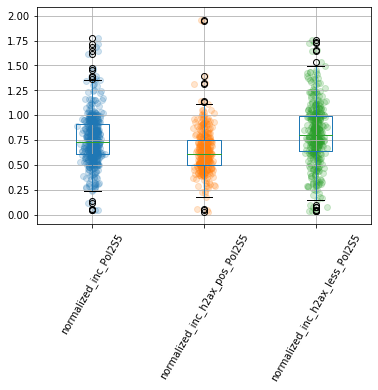

In [125]:
plt.figure();
from matplotlib.pyplot import figure

#figure(figsize=(6, 4), dpi=180)

analysis_df.boxplot(column=['normalized_inc_Pol2S5','normalized_inc_h2ax_pos_Pol2S5',
                                      'normalized_inc_h2ax_less_Pol2S5'],rot=60)





vals, xs = [], [] 

for i, subdf in enumerate([analysis_df['normalized_inc_Pol2S5'],
                           analysis_df['normalized_inc_h2ax_pos_Pol2S5'],
                          analysis_df['normalized_inc_h2ax_less_Pol2S5']]):
    #names.append(name)
    vals.append(subdf.tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))

for x, val in zip(xs, vals):
    plt.scatter(x, val,  alpha=0.2)


from scipy.stats import kruskal
p4 = kruskal(damaged_chr_df['ave_intensity_incorporated_chr_Pol2S5'],
                           no_damaged_chr_df['ave_intensity_incorporated_chr_Pol2S5'],
                          analysis_df['ave_intensity_nucleo-excluded_control_chr_Pol2S5'])


print(f"three samples comparision: {p4}")

In [ ]:
#analysis_df

In [ ]:
from scipy.stats import mannwhitneyu
U1, p1 = mannwhitneyu(analysis_df['normalized_inc_h2ax_pos_Pol2S5'], analysis_df['normalized_inc_h2ax_less_Pol2S5'])



from scipy.stats import kruskal


print(p1)


In [ ]:
analysis_df[analysis_df['H2ax_pos_less_ratio_Pol2S5']>0]

In [ ]:
pos_neg_ratio = same_cell_example_df['H2ax_pos_less_ratio_Pol2S5']
boxplot_same_foci= plt.boxplot(pos_neg_ratio)

In [129]:
analysis_df['h2ax_damage_level']=analysis_df['area_h2ax_within_incorporated_chr']/analysis_df['area_incorporated_chr']

damaged_chr_df = analysis_df[analysis_df['h2ax_damage_level']>=0.5]

partial_damaged_chr_df = analysis_df[analysis_df['h2ax_damage_level']<0.5]

med_damaged_chr_df = partial_damaged_chr_df[partial_damaged_chr_df['h2ax_damage_level']>=0.2]

no_damaged_chr_df = partial_damaged_chr_df[partial_damaged_chr_df['h2ax_damage_level']<0.2]

In [130]:
analysis_df.to_excel(r"D:\Analyzed_CellBio\Stam\Updated_measurement_for_all_background_subtracted_2_100_crop_Pol2_analyzed.xlsx", index=False)

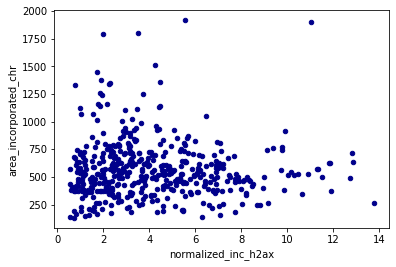

In [132]:
#analysis_df['normalized_inc_H2ax'] = analysis_df['ave_intensity_incorporated_chr_H2ax']/analysis_df['ave_intensity_nucleo-excluded_control_chr_H2ax']
#analysis_df


analysis_df.plot.scatter(x='normalized_inc_h2ax',y='area_incorporated_chr',c='DarkBlue')

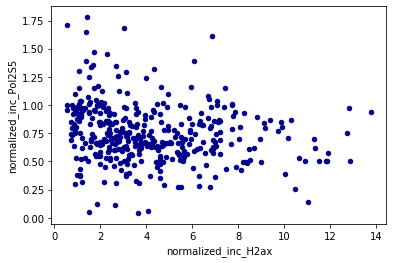

In [58]:
analysis_df.plot.scatter(x='normalized_inc_H2ax',y='normalized_inc_Pol2S5',c='DarkBlue')

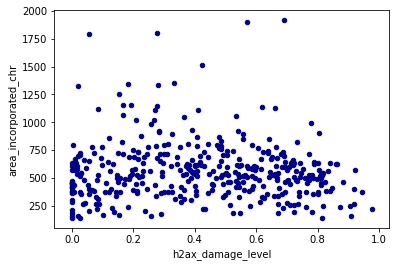

In [59]:
analysis_df.plot.scatter(x='h2ax_damage_level',y='area_incorporated_chr',c='DarkBlue')

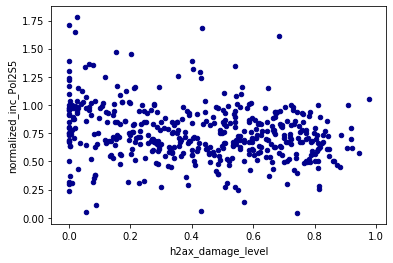

In [133]:
analysis_df.plot.scatter(x='h2ax_damage_level',y='normalized_inc_Pol2S5',c='DarkBlue')

In [135]:
print(damaged_chr_df['normalized_inc_Pol2S5'].mean())
print(damaged_chr_df['area_incorporated_chr'].mean())



print(med_damaged_chr_df['normalized_inc_Pol2S5'].mean())
print(med_damaged_chr_df['area_incorporated_chr'].mean())



print(no_damaged_chr_df['normalized_inc_Pol2S5'].mean())
print(no_damaged_chr_df['area_incorporated_chr'].mean())

#len(damaged_chr_df)
#len(med_damaged_chr_df)
#len(no_damaged_chr_df)

#len(analysis_df)

#no_damaged_chr_df['area_incorporated_chr'].mean()
#damaged_chr_df['area_incorporated_chr'].mean()

#analysis_df['area_h2ax_within_incorporated_chr'].mean()

#analysis_df['area_non_h2ax_within_incorporated_chr'].mean()

0.7127060482487955
536.3365853658537
0.7343122139784284
640.0138888888889
0.8480675377399159
538.05


MW comparision: 4.388321560669888e-06


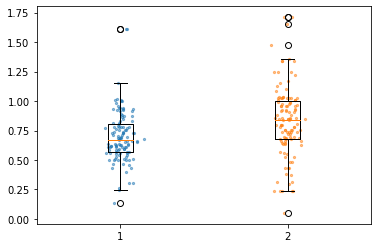

In [163]:


g1 = damaged_chr_df['normalized_inc_Pol2S5']
g2 = no_damaged_chr_df['normalized_inc_Pol2S5']
#g3 = analysis_df['ave_intensity_nucleo-excluded_control_chr_Pol2S5']

#sp_low = min(len(g1),len(g2),len(g3))
sp_low = min(len(g1),len(g2))

g1 = np.random.choice(g1, sp_low)
g2 = np.random.choice(g2, sp_low)
#g3 = np.random.choice(g3, sp_low)

boxplot_pol2= plt.boxplot([g1,g2], meanline = True)


vals, xs = [], [] 

for i, subdf in enumerate([g1,g2]):
    #names.append(name)
    vals.append(subdf.tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))

for x, val in zip(xs, vals):
    plt.scatter(x, val,  s = 5, alpha=0.5)


from scipy.stats import kruskal
#p4 = kruskal(g1,g2,g3)

U1, p1 = mannwhitneyu(g1,g2)

print(f"MW comparision: {p1}")




three samples comparision: KruskalResult(statistic=33.83301221322943, pvalue=4.50043760380227e-08)


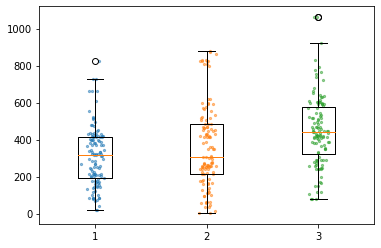

In [157]:
g1 = damaged_chr_df['ave_intensity_incorporated_chr_Pol2S5']
g2 = no_damaged_chr_df['ave_intensity_incorporated_chr_Pol2S5']
g3 = analysis_df['ave_intensity_nucleo-excluded_control_chr_Pol2S5']

sp_low = min(len(g1),len(g2),len(g3))

g1 = np.random.choice(g1, sp_low)
g2 = np.random.choice(g2, sp_low)
g3 = np.random.choice(g3, sp_low)

boxplot_pol2= plt.boxplot([g1,g2,g3], meanline = True)


vals, xs = [], [] 

for i, subdf in enumerate([g1,g2,g3]):
    #names.append(name)
    vals.append(subdf.tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))

for x, val in zip(xs, vals):
    plt.scatter(x, val,  s = 5, alpha=0.5)


from scipy.stats import kruskal
p4 = kruskal(g1,g2,g3)


print(f"three samples comparision: {p4}")

In [63]:
from scipy.stats import mannwhitneyu
U1, p1 = mannwhitneyu(damaged_chr_df['normalized_inc_Pol2S5'], no_damaged_chr_df['normalized_inc_Pol2S5'])

U2, p2 = mannwhitneyu(damaged_chr_df['normalized_inc_Pol2S5'], med_damaged_chr_df['normalized_inc_Pol2S5'])

U3, p3 = mannwhitneyu(med_damaged_chr_df['normalized_inc_Pol2S5'], no_damaged_chr_df['normalized_inc_Pol2S5'])

from scipy.stats import kruskal
p4 = kruskal(damaged_chr_df['normalized_inc_Pol2S5'],med_damaged_chr_df['normalized_inc_Pol2S5'],no_damaged_chr_df['normalized_inc_Pol2S5'])


print(f"damgage vs no damage: {p1}")

print(f"damgage vs med damage: {p2}")

print(f"med damgage vs no damage: {p3}")

print(f"three samples comparision: {p4}")

damgage vs no damage: 1.9972859919183074e-06
damgage vs med damage: 0.08802530035926875
med damgage vs no damage: 0.0004002926842440977
three samples comparision: KruskalResult(statistic=22.43378282644153, pvalue=1.344515939172475e-05)


c:\programdata\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


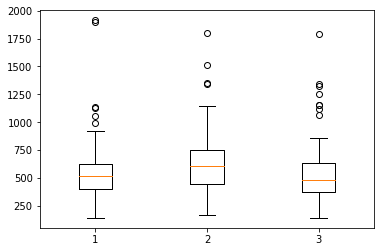

In [64]:
boxplot_size= plt.boxplot([damaged_chr_df['area_incorporated_chr'],med_damaged_chr_df['area_incorporated_chr'],no_damaged_chr_df['area_incorporated_chr']])

In [65]:
from scipy.stats import mannwhitneyu
U1, p1 = mannwhitneyu(damaged_chr_df['area_incorporated_chr'], no_damaged_chr_df['area_incorporated_chr'])

U2, p2 = mannwhitneyu(damaged_chr_df['area_incorporated_chr'], med_damaged_chr_df['area_incorporated_chr'])

U3, p3 = mannwhitneyu(med_damaged_chr_df['area_incorporated_chr'], no_damaged_chr_df['area_incorporated_chr'])

from scipy.stats import kruskal
p4 = kruskal(damaged_chr_df['area_incorporated_chr'],med_damaged_chr_df['area_incorporated_chr'],no_damaged_chr_df['area_incorporated_chr'])


print(p1)

print(p2)

print(p3)

print(p4)

0.13670760386586078
0.0002601867827186193
0.00019338203951995645
KruskalResult(statistic=16.92616663984062, pvalue=0.0002111201152396504)


In [75]:
damaged_chr_df_down_sample = np.random.choice(damaged_chr_df['normalized_inc_Pol2S5'], size=100)

med_damaged_chr_df_down_sample = np.random.choice(med_damaged_chr_df['normalized_inc_Pol2S5'], size=100)

no_damaged_chr_df_down_sample = np.random.choice(no_damaged_chr_df['normalized_inc_Pol2S5'], size=100)



from scipy.stats import mannwhitneyu
U1, p1 = mannwhitneyu(damaged_chr_df_down_sample, no_damaged_chr_df_down_sample)

U2, p2 = mannwhitneyu(damaged_chr_df_down_sample, med_damaged_chr_df_down_sample)

U3, p3 = mannwhitneyu(med_damaged_chr_df_down_sample, no_damaged_chr_df_down_sample)

from scipy.stats import kruskal
p4 = kruskal(damaged_chr_df_down_sample, med_damaged_chr_df_down_sample,no_damaged_chr_df_down_sample)


print(f"damgage vs no damage: {p1}")

print(f"damgage vs med damage: {p2}")

print(f"med damgage vs no damage: {p3}")

print(f"three samples comparision: {p4}")

damgage vs no damage: 0.004113338625274784
damgage vs med damage: 0.2726701191296431
med damgage vs no damage: 0.010300769983000063
three samples comparision: KruskalResult(statistic=8.478414615392197, pvalue=0.0144190171580655)


In [69]:
print(f"There are {len(damaged_chr_df)} damaged_chr.")

print(f"There are {len(med_damaged_chr_df)} med_damaged_chr.")

print(f"There are {len(no_damaged_chr_df)} no_damaged_chr.")



There are 168 damaged_chr.
There are 125 med_damaged_chr.
There are 104 no_damaged_chr.


In [ ]:
#no_damaged_chr_df[no_damaged_chr_df['area_incorporated_chr']==151]

## check the exp 3 cell number

In [50]:
combined_df_2[combined_df_2['exp_name'].str.contains('well3')]

,Unnamed: 0,batch_name,exp_name,position_id,cell_id,cell_xyz_coord,area_incorporated_chr,area_h2ax_within_incorporated_chr,area_less_h2ax_within_incorporated_chr,area_control_chr,...,ave_intensity_nucleo-excluded_control_chr_H2ax,ave_intensity_nucleolus_H2ax,ave_intensity_h2ax_pos_incorporated_chr_H2ax,ave_intensity_h2ax_less_incorporated_chr_H2ax,ave_intensity_incorporated_chr_Pol2S5,ave_intensity_control_chr_Pol2S5,ave_intensity_nucleo-excluded_control_chr_Pol2S5,ave_intensity_nucleolus_Pol2S5,ave_intensity_h2ax_pos_incorporated_chr_Pol2S5,ave_intensity_h2ax_less_incorporated_chr_Pol2S5
0,0,211007IF_210922exp_DamMN,well3_doxPlusAID,well3_m6T-488 H2AX-568 RNApol647_001.nd2_Pos2,1,"[[560, 950], 5]",1065,10,1055,20072,...,507.031642,290.610195,NaN,506.165814,136.324172,390.083742,445.680779,90.690675,NaN,129.990294
1,0,211007IF_210922exp_DamMN,well3_doxPlusAID,well3_m6T-488 H2AX-568 RNApol647_001.nd2_Pos3,1,"[[1170, 1033], 5]",851,595,256,30856,...,323.831458,176.074925,2212.345032,657.804674,266.769896,311.442627,361.233112,97.938738,202.918804,384.063356
2,0,211007IF_210922exp_DamMN,well3_doxPlusAID,well3_m6T-488 H2AX-568 RNApol647_001.nd2_Pos4,1,"[[1080, 1060], 6]",574,272,302,11381,...,401.426782,161.400260,2245.884738,895.708585,407.483767,413.034778,486.499217,124.942405,353.043763,422.490147
3,0,211007IF_210922exp_DamMN,well3_doxPlusAID,well3_m6T-488 H2AX-568 RNApol647_001.nd2_Pos5,1,"[[1100, 1040], 6]",464,156,308,13662,...,1093.328583,701.295658,2770.880866,2087.134101,274.585132,400.315315,471.866387,109.184304,256.132711,282.189325
4,0,211007IF_210922exp_DamMN,well3_doxPlusAID,well3_m6T-488 H2AX-568 RNApol647_001.nd2_Pos6,1,"[[1100, 1100], 6]",784,182,602,14865,...,223.144566,161.510503,1364.119390,327.034295,229.776064,252.993028,297.738215,78.437633,113.518789,267.959078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0,211007IF_210922exp_DamMN,well3_doxPlusAID,well3_m6T-488 H2AX-568 RNApol647_024.nd2_Pos4,1,"[[1090, 960], 6]",529,0,529,18905,...,246.853345,103.974647,NaN,302.016614,506.707116,343.603689,407.093137,92.090972,NaN,516.080538
72,0,211007IF_210922exp_DamMN,well3_doxPlusAID,well3_m6T-488 H2AX-568 RNApol647_025.nd2_Pos1,1,"[[1280, 850], 7]",678,2,676,16304,...,154.703183,95.086594,NaN,100.883362,243.400499,326.021897,381.821993,103.078810,NaN,236.235167
73,0,211007IF_210922exp_DamMN,well3_doxPlusAID,well3_m6T-488 H2AX-568 RNApol647_025.nd2_Pos2,1,"[[1320, 950], 7]",556,460,96,15685,...,349.092544,137.010023,1982.203198,NaN,285.322123,332.479855,389.032815,95.791818,237.293327,NaN
74,0,211007IF_210922exp_DamMN,well3_doxPlusAID,well3_m6T-488 H2AX-568 RNApol647_025.nd2_Pos3,1,"[[1270, 840], 6]",1236,338,898,19987,...,364.771235,190.741644,1389.830718,458.654347,324.050521,404.227799,464.952275,97.168999,211.617680,388.753147


In [47]:
len(combined_df_2[combined_df_2['exp_name'].str.contains('well3')])

76